# Weather Analysis and Forecasting in Uberlândia

This notebook explores the forecasting of climatic variables for the city of **Uberlândia (MG)** using historical data and the **XGBoost** model.  
The main objective is to simulate a **long-term forecasting** scenario, where the conditions for the next six months are predicted based on data available **until October 2, 2025**.

The generated forecasts are intended for **direct consumption by an application (APP)**, allowing for early visualization of future climatic conditions.

---

## Data Preparation and Treatment

We start by importing the essential libraries for analysis and modeling.  
Then, the data is loaded and prepared, including the combination of **Power Multilocation** information with climatic index data such as **SOI** and **ONI**.

To enrich the dataset, we perform a detailed **feature engineering** process, creating new variables that help the model capture seasonal and temporal patterns.

To demonstrate the methodology clearly and objectively, we filter the dataset to include only information from **Uberlândia**.  
The same logic, however, can be easily replicated for other cities.

---

## Training and Recurrent Forecasting

The dataset used for training covers the period from **2020 until October 2, 2025**.  
With this base, the models were trained simulating a realistic scenario, where forecasts are made without access to future data.

We train an **XGBoost** regression model for each of the target variables:

- Maximum temperature (`T2M_MAX`)
- Minimum temperature (`T2M_MIN`)
- Average temperature (`T2M`)
- Relative humidity (`RH2M`)
- Wind speed (`WS2M`)

This approach allows each model to specialize in forecasting its respective variable.

---

## Long-Term Forecast Simulation

The forecast is performed in a **recurrent (or recursive)** manner: for each predicted day, the **model's output** (forecast) is used as **input for the next day's forecast**.

This process is repeated to generate forecasts for the **six months following October 2, 2025**, simulating a scenario where **no real future data is available**.

The final result is a **DataFrame containing the generated predictions**, which can be used for analysis or integrated directly into the **APP**, allowing a comparative visualization between predicted and, in the future, actual values.

# 1. Data Acquisition and Manipulation

## Environment Setup and Library Import

This initial section sets up the working environment, ensuring that all necessary libraries are installed and imported. It includes packages for data manipulation (`pandas`, `numpy`), visualization (`matplotlib`, `seaborn`), and modeling (`xgboost`, `scikit-learn`).

Custom modules (`Endpoints`, `DataLoader`) are also imported for specific data loading and processing.


In [ ]:
# Setup
import sys, subprocess

def pip_install(pkgs):
    try:
        import importlib
        for p in pkgs:
            try:
                importlib.import_module(p.split("[")[0].replace("-","_"))
            except Exception:
                raise
        return
    except Exception:
        subprocess.check_call([sys.executable, "-m", "pip", "install", *pkgs])

pip_install([
    "pandas>=2.2.0",
    "numpy>=1.26",
    "scikit-learn>=1.4",
    "matplotlib>=3.8",
    "seaborn>=0.13",
    "xgboost>=1.7.0", # Added to use XGBoost
])

import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from xgboost import XGBRegressor # Import XGBoost

from endpoints import Endpoints # Import Endpoints
from data_loader import DataLoader # Import DataLoader

sns.set_theme(style="whitegrid")

endpoints = Endpoints()
data_loader = DataLoader(endpoints=endpoints)


In [ ]:
# Loading Datasets

# Define the search period (example: last 8 years)
end_date = pd.Timestamp.now().normalize()
start_date = end_date - timedelta(days=8*365)

# 1. Load consolidated daily data from NASA POWER (MultiLocation)
# Search for the most recent file containing "power_MultiLocation"
power_files = sorted(Path(".").glob("power_MultiLocation_*.csv"))
if not power_files:
    raise FileNotFoundError("No power_MultiLocation_*.csv file found. Run build_dataset.ipynb first.")

latest_power_file = power_files[-1]
print(f"Loading consolidated POWER data from: {latest_power_file.name}")
df_daily = pd.read_csv(latest_power_file, index_col='date', parse_dates=True)

# Note: If the 'power_MultiLocation_*.csv' file is not found,
# run the 'build_dataset.ipynb' notebook to generate the latest data.

print("POWER data loaded.")
print(df_daily.head())

# Load ENSO index data (SOI, ONI)
print("Loading SOI data...")
soi_data = data_loader.load_soi_data()
print("Loading ONI (Niño 3.4) data...")
on_data = data_loader.load_nino34_oni_data()

# Define target columns for forecasting (keep for future reference)
target_cols = ['WS2M']

print("All raw datasets loaded successfully.")

Carregando dados consolidados do POWER de: power_MultiLocation_2017-10-07_2025-10-05.csv
Dados POWER carregados.
            T2M_MAX  T2M_MIN    T2M   RH2M  WS2M  PRECTOTCORR  \
date                                                            
2017-10-07    26.17    24.09  24.91  77.24  4.38         2.48   
2017-10-08    26.15    24.00  24.85  77.25  4.84         1.26   
2017-10-09    26.22    23.70  24.86  75.37  4.76         0.40   
2017-10-10    25.92    23.33  24.56  77.75  4.39         0.38   
2017-10-11    25.64    23.65  24.52  79.67  4.65         0.23   

            ALLSKY_SFC_SW_DWN  ALLSKY_SFC_LW_DWN  T2MDEW      PS   QV2M  \
date                                                                      
2017-10-07              20.25              34.69   20.64  101.47  15.04   
2017-10-08              20.13              33.90   20.60  101.43  15.00   
2017-10-09              22.57              33.41   20.20  101.39  14.64   
2017-10-10              24.52              32.99   20.41

In [ ]:
# Resets the index and renames the column to 'date'
soi_data = soi_data.reset_index(names=['date'])
on_data = on_data.reset_index(names=['date'])

# Converts dates to a 'Period' object (year-month)
soi_data['month_period'] = soi_data['date'].dt.to_period('M')
on_data['month_period'] = on_data['date'].dt.to_period('M')

In [4]:
soi_on_data = soi_data.merge(on_data[['date', 'ANOM']], how='inner', on='date')

In [ ]:
# Create lags for the SOI column
soi_on_data['SOI_L1M'] = soi_on_data['SOI'].shift(1)
soi_on_data['SOI_L2M'] = soi_on_data['SOI'].shift(2)
soi_on_data['SOI_L3M'] = soi_on_data['SOI'].shift(3)

# Create lags for the ANOM column
soi_on_data['ANOM_L1M'] = soi_on_data['ANOM'].shift(1)
soi_on_data['ANOM_L2M'] = soi_on_data['ANOM'].shift(2)
soi_on_data['ANOM_L3M'] = soi_on_data['ANOM'].shift(3)

In [6]:
df_daily.head()

,T2M_MAX,T2M_MIN,T2M,RH2M,WS2M,PRECTOTCORR,ALLSKY_SFC_SW_DWN,ALLSKY_SFC_LW_DWN,T2MDEW,PS,QV2M,ALLSKY_KT,ALLSKY_SFC_SW_DIFF,TOA_SW_DWN,name,latitude,longitude
date,,,,,,,,,,,,,,,,,
2017-10-07,26.17,24.09,24.91,77.24,4.38,2.48,20.25,34.69,20.64,101.47,15.04,0.54,8.97,37.73,Aracaju,-10.9111,-37.0717
2017-10-08,26.15,24.00,24.85,77.25,4.84,1.26,20.13,33.90,20.60,101.43,15.00,0.53,10.42,37.80,Aracaju,-10.9111,-37.0717
2017-10-09,26.22,23.70,24.86,75.37,4.76,0.40,22.57,33.41,20.20,101.39,14.64,0.60,9.50,37.87,Aracaju,-10.9111,-37.0717
2017-10-10,25.92,23.33,24.56,77.75,4.39,0.38,24.52,32.99,20.41,101.37,14.84,0.65,7.80,37.93,Aracaju,-10.9111,-37.0717
2017-10-11,25.64,23.65,24.52,79.67,4.65,0.23,21.86,33.23,20.79,101.32,15.20,0.58,9.27,37.99,Aracaju,-10.9111,-37.0717


In [7]:
df_daily = df_daily.reset_index(names=['date'])
df_daily['date'] = pd.to_datetime(df_daily['date'])
#df_daily = df_daily[df_daily['date'] < '2025-06-30']
df_daily = df_daily.sort_values(by=['name', 'date'])

In [ ]:
colunas = [
    'T2M_MAX', 'T2M_MIN', 'T2M', 'RH2M', 'WS2M', 'PRECTOTCORR', 'ALLSKY_SFC_SW_DWN',
    'ALLSKY_SFC_LW_DWN', 'T2MDEW', 'PS', 'QV2M', 'ALLSKY_KT', 'ALLSKY_SFC_SW_DIFF', 'TOA_SW_DWN'
]

# List of lag periods in days
lags = [1, 2, 7, 15, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 365]

# Create a dictionary to store the new lag columns
lags_dict = {}

# Iterate over each column and create the lag series
for coluna in colunas:
    for lag in lags:
        nome_lag = f'{coluna}_L{lag}D'
        # Store the new series in the dictionary
        lags_dict[nome_lag] = df_daily[coluna].shift(lag)

# Create a new DataFrame from the lag dictionary
df_lags = pd.DataFrame(lags_dict)
df_daily = pd.concat([df_daily, df_lags], axis=1)
df_daily = df_daily[df_daily['date'] > '2020-01-01']

In [9]:
df_daily.head()

,date,T2M_MAX,T2M_MIN,T2M,RH2M,WS2M,PRECTOTCORR,ALLSKY_SFC_SW_DWN,ALLSKY_SFC_LW_DWN,T2MDEW,PS,QV2M,ALLSKY_KT,ALLSKY_SFC_SW_DIFF,TOA_SW_DWN,name,latitude,longitude,T2M_MAX_L1D,T2M_MAX_L2D,T2M_MAX_L7D,T2M_MAX_L15D,T2M_MAX_L30D,T2M_MAX_L60D,T2M_MAX_L90D,T2M_MAX_L120D,T2M_MAX_L150D,T2M_MAX_L180D,T2M_MAX_L210D,T2M_MAX_L240D,T2M_MAX_L270D,T2M_MAX_L300D,T2M_MAX_L330D,T2M_MAX_L365D,T2M_MIN_L1D,T2M_MIN_L2D,T2M_MIN_L7D,T2M_MIN_L15D,T2M_MIN_L30D,T2M_MIN_L60D,T2M_MIN_L90D,T2M_MIN_L120D,T2M_MIN_L150D,T2M_MIN_L180D,T2M_MIN_L210D,T2M_MIN_L240D,T2M_MIN_L270D,T2M_MIN_L300D,T2M_MIN_L330D,T2M_MIN_L365D,...,QV2M_L330D,QV2M_L365D,ALLSKY_KT_L1D,ALLSKY_KT_L2D,ALLSKY_KT_L7D,ALLSKY_KT_L15D,ALLSKY_KT_L30D,ALLSKY_KT_L60D,ALLSKY_KT_L90D,ALLSKY_KT_L120D,ALLSKY_KT_L150D,ALLSKY_KT_L180D,ALLSKY_KT_L210D,ALLSKY_KT_L240D,ALLSKY_KT_L270D,ALLSKY_KT_L300D,ALLSKY_KT_L330D,ALLSKY_KT_L365D,ALLSKY_SFC_SW_DIFF_L1D,ALLSKY_SFC_SW_DIFF_L2D,ALLSKY_SFC_SW_DIFF_L7D,ALLSKY_SFC_SW_DIFF_L15D,ALLSKY_SFC_SW_DIFF_L30D,ALLSKY_SFC_SW_DIFF_L60D,ALLSKY_SFC_SW_DIFF_L90D,ALLSKY_SFC_SW_DIFF_L120D,ALLSKY_SFC_SW_DIFF_L150D,ALLSKY_SFC_SW_DIFF_L180D,ALLSKY_SFC_SW_DIFF_L210D,ALLSKY_SFC_SW_DIFF_L240D,ALLSKY_SFC_SW_DIFF_L270D,ALLSKY_SFC_SW_DIFF_L300D,ALLSKY_SFC_SW_DIFF_L330D,ALLSKY_SFC_SW_DIFF_L365D,TOA_SW_DWN_L1D,TOA_SW_DWN_L2D,TOA_SW_DWN_L7D,TOA_SW_DWN_L15D,TOA_SW_DWN_L30D,TOA_SW_DWN_L60D,TOA_SW_DWN_L90D,TOA_SW_DWN_L120D,TOA_SW_DWN_L150D,TOA_SW_DWN_L180D,TOA_SW_DWN_L210D,TOA_SW_DWN_L240D,TOA_SW_DWN_L270D,TOA_SW_DWN_L300D,TOA_SW_DWN_L330D,TOA_SW_DWN_L365D
100131,2020-01-02,6.01,0.82,2.78,96.23,5.21,0.45,0.98,26.39,2.23,102.28,4.41,0.15,0.83,6.30,Amsterdã,52.3676,4.9041,1.64,7.53,5.54,5.54,7.60,11.45,13.80,18.61,23.06,19.52,17.31,12.08,18.26,8.82,4.83,7.01,0.09,1.37,4.12,4.37,4.61,8.22,7.94,14.63,17.88,12.15,12.37,6.63,7.70,6.22,1.00,3.18,...,4.59,4.12,0.22,0.53,0.22,0.41,0.39,0.29,0.20,0.24,0.51,0.30,0.52,0.42,0.58,0.53,0.19,0.29,1.11,1.85,1.18,1.52,1.36,2.78,3.04,4.84,9.51,9.35,11.59,10.48,7.02,4.57,1.80,1.34,6.24,6.20,6.03,6.01,6.79,11.44,19.28,28.25,36.09,40.84,40.97,36.35,28.38,19.14,11.17,6.31
100132,2020-01-03,8.45,4.83,6.71,92.00,5.50,7.24,0.78,26.55,5.51,101.71,5.58,0.12,0.68,6.35,Amsterdã,52.3676,4.9041,6.01,1.64,4.27,10.79,5.60,11.88,14.26,16.92,22.44,17.78,21.80,12.68,17.81,9.89,8.45,6.21,0.82,0.09,-0.09,5.41,0.66,7.87,7.01,12.11,16.72,11.62,10.98,6.52,6.90,6.37,4.62,3.48,...,5.20,4.49,0.15,0.22,0.58,0.30,0.55,0.27,0.48,0.47,0.55,0.43,0.40,0.23,0.62,0.35,0.52,0.43,0.83,1.11,1.13,1.58,1.16,2.23,6.26,8.54,11.68,11.65,11.38,6.82,6.13,5.15,3.19,1.41,6.30,6.24,6.05,6.00,6.71,11.22,18.99,27.95,35.87,40.75,41.04,36.56,28.68,19.45,11.39,6.37
100133,2020-01-04,7.51,5.18,6.42,91.83,4.66,0.89,1.48,26.01,5.21,102.81,5.38,0.23,1.27,6.42,Amsterdã,52.3676,4.9041,8.45,6.01,2.15,10.31,4.70,11.19,9.52,18.26,21.78,16.56,17.02,15.64,13.05,6.59,8.19,6.27,4.83,0.82,-0.45,7.15,0.57,7.90,7.91,12.32,15.94,12.00,12.51,7.53,5.47,2.78,4.37,3.76,...,5.56,4.83,0.12,0.15,0.32,0.17,0.28,0.29,0.16,0.31,0.58,0.42,0.30,0.58,0.65,0.15,0.18,0.10,0.68,0.83,1.69,0.90,1.42,2.48,2.60,7.25,10.45,12.49,8.98,9.26,7.22,2.39,1.81,0.58,6.35,6.30,6.08,5.99,6.63,11.01,18.70,27.66,35.64,40.65,41.12,36.78,28.98,19.75,11.61,6.43
100134,2020-01-05,7.40,5.57,6.14,94.12,3.45,0.48,0.74,27.29,5.28,103.18,5.37,0.11,0.58,6.48,Amsterdã,52.3676,4.9041,7.51,8.45,3.59,7.96,9.04,10.38,11.93,16.56,22.11,18.72,18.67,12.77,9.55,7.11,8.98,7.59,5.18,4.83,0.21,5.31,4.64,6.00,5.22,12.52,16.18,12.11,11.88,6.80,3.13,3.22,6.54,5.96,...,5.25,5.30,0.23,0.12,0.28,0.24,0.09,0.43,0.30,0.45,0.62,0.58,0.56,0.52,0.73,0.40,0.46,0.21,1.27,0.68,1.48,1.08,0.54,2.77,4.61,6.95,8.50,10.82,12.27,9.35,5.25,5.74,2.45,1.01,6.42,6.35,6.12,5.98,6.55,10.80,18.41,27.37,35.42,40.55,41.18,36.99,29.27,20.06,11.84,6.50
100135,2020-01-06,6.42,2.73,5.01,91.11,4.93,0.52,1.90,26.82,3.68,102.31,4.86,0.29,1.05,6.56,Amsterdã,52.3676,4.9041,7.40,7.51,6.09,8.23,9.04,9.24,16.38,17.63,25.21,18.14,20.87,13.04,9.54,8.44,7.44,7.07,5.57,5.18,1.01,4.98,6.47,5.61,11.69,11.88,15.80,11.94,13.24,5.22

In [10]:
df_daily['month_period'] = df_daily['date'].dt.to_period('M')
df_daily['prev_month_period'] = df_daily['month_period'] - 1

In [ ]:
# Join with SOI data
df_daily_full = pd.merge(
    df_daily,
    soi_on_data[['month_period', 'SOI', 'SOI_L1M', 'SOI_L2M', 'SOI_L3M', 'ANOM', 'ANOM_L1M', 'ANOM_L2M', 'ANOM_L3M']],
    left_on='prev_month_period',
    right_on='month_period',
    how='left',
)
df_daily_full = df_daily_full.drop(columns=['month_period_y', 'month_period_x', 'prev_month_period'])

In [ ]:
# 1. Time-Based Seasonality Variables

# Extract day of year, day of week, week of year, and month
df_daily_full['month'] = df_daily_full['date'].dt.month
df_daily_full['day_of_year'] = df_daily_full['date'].dt.dayofyear
df_daily_full['day_of_week'] = df_daily_full['date'].dt.dayofweek # 0=Monday, 6=Sunday
df_daily_full['week_of_year'] = df_daily_full['date'].dt.isocalendar().week.astype(int)

# Check if it's a weekend
df_daily_full['is_weekend'] = (df_daily_full['date'].dt.weekday >= 5).astype(int)

# 2. Continuous Seasonality Variables (Sine and Cosine)

# Seasonality for day of year (annual)
df_daily_full['day_of_year_sin'] = np.sin(2 * np.pi * df_daily_full['day_of_year'] / 365.25)
df_daily_full['day_of_year_cos'] = np.cos(2 * np.pi * df_daily_full['day_of_year'] / 365.25)

# Seasonality for week of year (annual)
df_daily_full['week_of_year_sin'] = np.sin(2 * np.pi * df_daily_full['week_of_year'] / 52.0)
df_daily_full['week_of_year_cos'] = np.cos(2 * np.pi * df_daily_full['week_of_year'] / 52.0)

# Seasonality for day of week (weekly)
df_daily_full['day_of_week_sin'] = np.sin(2 * np.pi * df_daily_full['day_of_week'] / 7.0)
df_daily_full['day_of_week_cos'] = np.cos(2 * np.pi * df_daily_full['day_of_week'] / 7.0)

# 3. Additional Variables (Ideas)
# Depending on your problem, these variables might be useful:

# Seasonality for month
df_daily_full['month_sin'] = np.sin(2 * np.pi * df_daily_full['month'] / 12.0)
df_daily_full['month_cos'] = np.cos(2 * np.pi * df_daily_full['month'] / 12.0)

# Year (if you have multiple years of data)
df_daily_full['year'] = df_daily_full['date'].dt.year

In [13]:
df_daily_full.head()

,date,T2M_MAX,T2M_MIN,T2M,RH2M,WS2M,PRECTOTCORR,ALLSKY_SFC_SW_DWN,ALLSKY_SFC_LW_DWN,T2MDEW,PS,QV2M,ALLSKY_KT,ALLSKY_SFC_SW_DIFF,TOA_SW_DWN,name,latitude,longitude,T2M_MAX_L1D,T2M_MAX_L2D,T2M_MAX_L7D,T2M_MAX_L15D,T2M_MAX_L30D,T2M_MAX_L60D,T2M_MAX_L90D,T2M_MAX_L120D,T2M_MAX_L150D,T2M_MAX_L180D,T2M_MAX_L210D,T2M_MAX_L240D,T2M_MAX_L270D,T2M_MAX_L300D,T2M_MAX_L330D,T2M_MAX_L365D,T2M_MIN_L1D,T2M_MIN_L2D,T2M_MIN_L7D,T2M_MIN_L15D,T2M_MIN_L30D,T2M_MIN_L60D,T2M_MIN_L90D,T2M_MIN_L120D,T2M_MIN_L150D,T2M_MIN_L180D,T2M_MIN_L210D,T2M_MIN_L240D,T2M_MIN_L270D,T2M_MIN_L300D,T2M_MIN_L330D,T2M_MIN_L365D,...,ALLSKY_SFC_SW_DIFF_L30D,ALLSKY_SFC_SW_DIFF_L60D,ALLSKY_SFC_SW_DIFF_L90D,ALLSKY_SFC_SW_DIFF_L120D,ALLSKY_SFC_SW_DIFF_L150D,ALLSKY_SFC_SW_DIFF_L180D,ALLSKY_SFC_SW_DIFF_L210D,ALLSKY_SFC_SW_DIFF_L240D,ALLSKY_SFC_SW_DIFF_L270D,ALLSKY_SFC_SW_DIFF_L300D,ALLSKY_SFC_SW_DIFF_L330D,ALLSKY_SFC_SW_DIFF_L365D,TOA_SW_DWN_L1D,TOA_SW_DWN_L2D,TOA_SW_DWN_L7D,TOA_SW_DWN_L15D,TOA_SW_DWN_L30D,TOA_SW_DWN_L60D,TOA_SW_DWN_L90D,TOA_SW_DWN_L120D,TOA_SW_DWN_L150D,TOA_SW_DWN_L180D,TOA_SW_DWN_L210D,TOA_SW_DWN_L240D,TOA_SW_DWN_L270D,TOA_SW_DWN_L300D,TOA_SW_DWN_L330D,TOA_SW_DWN_L365D,SOI,SOI_L1M,SOI_L2M,SOI_L3M,ANOM,ANOM_L1M,ANOM_L2M,ANOM_L3M,month,day_of_year,day_of_week,week_of_year,is_weekend,day_of_year_sin,day_of_year_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,year
0,2020-01-02,6.01,0.82,2.78,96.23,5.21,0.45,0.98,26.39,2.23,102.28,4.41,0.15,0.83,6.30,Amsterdã,52.3676,4.9041,1.64,7.53,5.54,5.54,7.6,11.45,13.80,18.61,23.06,19.52,17.31,12.08,18.26,8.82,4.83,7.01,0.09,1.37,4.12,4.37,4.61,8.22,7.94,14.63,17.88,12.15,12.37,6.63,7.70,6.22,1.00,3.18,...,1.36,2.78,3.04,4.84,9.51,9.35,11.59,10.48,7.02,4.57,1.80,1.34,6.24,6.20,6.03,6.01,6.79,11.44,19.28,28.25,36.09,40.84,40.97,36.35,28.38,19.14,11.17,6.31,-0.6,-0.8,-1.4,-0.4,0.55,0.51,0.51,0.35,1,2,3,1,0,0.034398,0.999408,0.120537,0.992709,0.433884,-0.900969,0.5,0.866025,2020
1,2020-01-02,6.01,0.82,2.78,96.23,5.21,0.45,0.98,26.39,2.23,102.28,4.41,0.15,0.83,6.30,Amsterdã,52.3676,4.9041,1.64,7.53,5.54,5.54,7.6,11.45,13.80,18.61,23.06,19.52,17.31,12.08,18.26,8.82,4.83,7.01,0.09,1.37,4.12,4.37,4.61,8.22,7.94,14.63,17.88,12.15,12.37,6.63,7.70,6.22,1.00,3.18,...,1.36,2.78,3.04,4.84,9.51,9.35,11.59,10.48,7.02,4.57,1.80,1.34,6.24,6.20,6.03,6.01,6.79,11.44,19.28,28.25,36.09,40.84,40.97,36.35,28.38,19.14,11.17,6.31,-0.9,-0.6,-0.8,-1.4,0.55,0.55,0.51,0.51,1,2,3,1,0,0.034398,0.999408,0.120537,0.992709,0.433884,-0.900969,0.5,0.866025,2020
2,2020-01-03,8.45,4.83,6.71,92.00,5.50,7.24,0.78,26.55,5.51,101.71,5.58,0.12,0.68,6.35,Amsterdã,52.3676,4.9041,6.01,1.64,4.27,10.79,5.6,11.88,14.26,16.92,22.44,17.78,21.80,12.68,17.81,9.89,8.45,6.21,0.82,0.09,-0.09,5.41,0.66,7.87,7.01,12.11,16.72,11.62,10.98,6.52,6.90,6.37,4.62,3.48,...,1.16,2.23,6.26,8.54,11.68,11.65,11.38,6.82,6.13,5.15,3.19,1.41,6.30,6.24,6.05,6.00,6.71,11.22,18.99,27.95,35.87,40.75,41.04,36.56,28.68,19.45,11.39,6.37,-0.6,-0.8,-1.4,-0.4,0.55,0.51,0.51,0.35,1,3,4,1,0,0.051584,0.998669,0.120537,0.992709,-0.433884,-0.900969,0.5,0.866025,2020
3,2020-01-03,8.45,4.83,6.71,92.00,5.50,7.24,0.78,26.55,5.51,101.71,5.58,0.12,0.68,6.35,Amsterdã,52.3676,4.9041,6.01,1.64,4.27,10.79,5.6,11.88,14.26,16.92,22.44,17.78,21.80,12.68,17.81,9.89,8.45,6.21,0.82,0.09,-0.09,5.41,0.66,7.87,7.01,12.11,16.72,11.62,10.98,6.52,6.90,6.37,4.62,3.48,...,1.16,2.23,6.26,8.54,11.68,11.65,11.38,6.82,6.13,5.15,3.19,1.41,6.30,6.24,6.05,6.00,6.71,11.22,18.99,27.95,35.87,40.75,41.04,36.56,28.68,19.45,11.39,6.37,-0.9,-0.6,-0.8,-1.4,0.55,0.55,0.51,0.51,1,3,4,1,0,0.051584,0.998669,0.120537,0.992709,-0.433884,-0.900969,0.5,0.866025,2020
4,2020-01-04,7.51,5.18,6.42,91.83,4.66,0.89,1.48,26.01,5.21,102.81,5.38,0.23,1.27,6.42,Amsterdã,52.3676,4.9041,8.45,6.01,2.15,10.31,4.7,11.19,9.52,18.26,21.78,16.56,17.02,15.64,13.05,6.59,8.19,6.27,4.83,0.82,-0.45,7.15,0.57,7.90,7.91,12.32,15.94,12.00,12.51,7.53,5.47,2.78,4.37,3.76,...,1.42,2.48,2.60,7.25,10.45,12.49,8.98,9.26,7.22,2.39,1.81,0.58,6.35,6.3

In [ ]:
# List of columns to remove
colunas_a_remover = [
    'PRECTOTCORR', 'ALLSKY_SFC_SW_DWN', 'ALLSKY_SFC_LW_DWN',
    'T2MDEW', 'PS', 'QV2M', 'ALLSKY_KT', 'ALLSKY_SFC_SW_DIFF', 'TOA_SW_DWN'
]

df = df_daily_full.drop(columns=colunas_a_remover)

In [16]:
df.head()

,date,T2M_MAX,T2M_MIN,T2M,RH2M,WS2M,name,latitude,longitude,T2M_MAX_L1D,T2M_MAX_L2D,T2M_MAX_L7D,T2M_MAX_L15D,T2M_MAX_L30D,T2M_MAX_L60D,T2M_MAX_L90D,T2M_MAX_L120D,T2M_MAX_L150D,T2M_MAX_L180D,T2M_MAX_L210D,T2M_MAX_L240D,T2M_MAX_L270D,T2M_MAX_L300D,T2M_MAX_L330D,T2M_MAX_L365D,T2M_MIN_L1D,T2M_MIN_L2D,T2M_MIN_L7D,T2M_MIN_L15D,T2M_MIN_L30D,T2M_MIN_L60D,T2M_MIN_L90D,T2M_MIN_L120D,T2M_MIN_L150D,T2M_MIN_L180D,T2M_MIN_L210D,T2M_MIN_L240D,T2M_MIN_L270D,T2M_MIN_L300D,T2M_MIN_L330D,T2M_MIN_L365D,T2M_L1D,T2M_L2D,T2M_L7D,T2M_L15D,T2M_L30D,T2M_L60D,T2M_L90D,T2M_L120D,T2M_L150D,...,ALLSKY_SFC_SW_DIFF_L30D,ALLSKY_SFC_SW_DIFF_L60D,ALLSKY_SFC_SW_DIFF_L90D,ALLSKY_SFC_SW_DIFF_L120D,ALLSKY_SFC_SW_DIFF_L150D,ALLSKY_SFC_SW_DIFF_L180D,ALLSKY_SFC_SW_DIFF_L210D,ALLSKY_SFC_SW_DIFF_L240D,ALLSKY_SFC_SW_DIFF_L270D,ALLSKY_SFC_SW_DIFF_L300D,ALLSKY_SFC_SW_DIFF_L330D,ALLSKY_SFC_SW_DIFF_L365D,TOA_SW_DWN_L1D,TOA_SW_DWN_L2D,TOA_SW_DWN_L7D,TOA_SW_DWN_L15D,TOA_SW_DWN_L30D,TOA_SW_DWN_L60D,TOA_SW_DWN_L90D,TOA_SW_DWN_L120D,TOA_SW_DWN_L150D,TOA_SW_DWN_L180D,TOA_SW_DWN_L210D,TOA_SW_DWN_L240D,TOA_SW_DWN_L270D,TOA_SW_DWN_L300D,TOA_SW_DWN_L330D,TOA_SW_DWN_L365D,SOI,SOI_L1M,SOI_L2M,SOI_L3M,ANOM,ANOM_L1M,ANOM_L2M,ANOM_L3M,month,day_of_year,day_of_week,week_of_year,is_weekend,day_of_year_sin,day_of_year_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,year
0,2020-01-02,6.01,0.82,2.78,96.23,5.21,Amsterdã,52.3676,4.9041,1.64,7.53,5.54,5.54,7.6,11.45,13.80,18.61,23.06,19.52,17.31,12.08,18.26,8.82,4.83,7.01,0.09,1.37,4.12,4.37,4.61,8.22,7.94,14.63,17.88,12.15,12.37,6.63,7.70,6.22,1.00,3.18,0.89,4.88,4.83,5.00,6.06,9.96,10.03,16.70,20.42,...,1.36,2.78,3.04,4.84,9.51,9.35,11.59,10.48,7.02,4.57,1.80,1.34,6.24,6.20,6.03,6.01,6.79,11.44,19.28,28.25,36.09,40.84,40.97,36.35,28.38,19.14,11.17,6.31,-0.6,-0.8,-1.4,-0.4,0.55,0.51,0.51,0.35,1,2,3,1,0,0.034398,0.999408,0.120537,0.992709,0.433884,-0.900969,0.5,0.866025,2020
1,2020-01-02,6.01,0.82,2.78,96.23,5.21,Amsterdã,52.3676,4.9041,1.64,7.53,5.54,5.54,7.6,11.45,13.80,18.61,23.06,19.52,17.31,12.08,18.26,8.82,4.83,7.01,0.09,1.37,4.12,4.37,4.61,8.22,7.94,14.63,17.88,12.15,12.37,6.63,7.70,6.22,1.00,3.18,0.89,4.88,4.83,5.00,6.06,9.96,10.03,16.70,20.42,...,1.36,2.78,3.04,4.84,9.51,9.35,11.59,10.48,7.02,4.57,1.80,1.34,6.24,6.20,6.03,6.01,6.79,11.44,19.28,28.25,36.09,40.84,40.97,36.35,28.38,19.14,11.17,6.31,-0.9,-0.6,-0.8,-1.4,0.55,0.55,0.51,0.51,1,2,3,1,0,0.034398,0.999408,0.120537,0.992709,0.433884,-0.900969,0.5,0.866025,2020
2,2020-01-03,8.45,4.83,6.71,92.00,5.50,Amsterdã,52.3676,4.9041,6.01,1.64,4.27,10.79,5.6,11.88,14.26,16.92,22.44,17.78,21.80,12.68,17.81,9.89,8.45,6.21,0.82,0.09,-0.09,5.41,0.66,7.87,7.01,12.11,16.72,11.62,10.98,6.52,6.90,6.37,4.62,3.48,2.78,0.89,2.41,8.23,3.36,9.35,10.27,15.01,19.45,...,1.16,2.23,6.26,8.54,11.68,11.65,11.38,6.82,6.13,5.15,3.19,1.41,6.30,6.24,6.05,6.00,6.71,11.22,18.99,27.95,35.87,40.75,41.04,36.56,28.68,19.45,11.39,6.37,-0.6,-0.8,-1.4,-0.4,0.55,0.51,0.51,0.35,1,3,4,1,0,0.051584,0.998669,0.120537,0.992709,-0.433884,-0.900969,0.5,0.866025,2020
3,2020-01-03,8.45,4.83,6.71,92.00,5.50,Amsterdã,52.3676,4.9041,6.01,1.64,4.27,10.79,5.6,11.88,14.26,16.92,22.44,17.78,21.80,12.68,17.81,9.89,8.45,6.21,0.82,0.09,-0.09,5.41,0.66,7.87,7.01,12.11,16.72,11.62,10.98,6.52,6.90,6.37,4.62,3.48,2.78,0.89,2.41,8.23,3.36,9.35,10.27,15.01,19.45,...,1.16,2.23,6.26,8.54,11.68,11.65,11.38,6.82,6.13,5.15,3.19,1.41,6.30,6.24,6.05,6.00,6.71,11.22,18.99,27.95,35.87,40.75,41.04,36.56,28.68,19.45,11.39,6.37,-0.9,-0.6,-0.8,-1.4,0.55,0.55,0.51,0.51,1,3,4,1,0,0.051584,0.998669,0.120537,0.992709,-0.433884,-0.900969,0.5,0.866025,2020
4,2020-01-04,7.51,5.18,6.42,91.83,4.66,Amsterdã,52.3676,4.9041,8.45,6.01,2.15,10.31,4.7,11.19,9.52,18.26,21.78,16.56,17.02,15.64,13.05,6.59,8.19,6.27,4.83,0.82,-0.45,7.15,0.57,7.90,7.91,12.32,15.94,12.00,12.51,7.53,5.47,2.78,4.37,3.76,6.71,2.78,0.66,8.59,3.17,9.25,8.72,15.32,19.16,...,1.42,2.48,2.60,7.25,10.45,12.49,8.98,9.26,7.22,2.39,1.81,0.58,6.35,6.30,6.08,5.99,6.63,11.01,1

In [17]:
train_end_date = '2025-10-02'
valid_end_date = '2026-04-01'

train = df[df['date'] <= train_end_date].copy()
valid = df[df['date'] > train_end_date].copy()

In [18]:
train_udi = train[train['name'] == 'Uberlândia']
valid_udi = valid[valid['name'] == 'Uberlândia']

train_udi.shape, valid_udi.shape

((3958, 255), (3, 255))

In [19]:
train_udi.head(2)

,date,T2M_MAX,T2M_MIN,T2M,RH2M,WS2M,name,latitude,longitude,T2M_MAX_L1D,T2M_MAX_L2D,T2M_MAX_L7D,T2M_MAX_L15D,T2M_MAX_L30D,T2M_MAX_L60D,T2M_MAX_L90D,T2M_MAX_L120D,T2M_MAX_L150D,T2M_MAX_L180D,T2M_MAX_L210D,T2M_MAX_L240D,T2M_MAX_L270D,T2M_MAX_L300D,T2M_MAX_L330D,T2M_MAX_L365D,T2M_MIN_L1D,T2M_MIN_L2D,T2M_MIN_L7D,T2M_MIN_L15D,T2M_MIN_L30D,T2M_MIN_L60D,T2M_MIN_L90D,T2M_MIN_L120D,T2M_MIN_L150D,T2M_MIN_L180D,T2M_MIN_L210D,T2M_MIN_L240D,T2M_MIN_L270D,T2M_MIN_L300D,T2M_MIN_L330D,T2M_MIN_L365D,T2M_L1D,T2M_L2D,T2M_L7D,T2M_L15D,T2M_L30D,T2M_L60D,T2M_L90D,T2M_L120D,T2M_L150D,...,ALLSKY_SFC_SW_DIFF_L30D,ALLSKY_SFC_SW_DIFF_L60D,ALLSKY_SFC_SW_DIFF_L90D,ALLSKY_SFC_SW_DIFF_L120D,ALLSKY_SFC_SW_DIFF_L150D,ALLSKY_SFC_SW_DIFF_L180D,ALLSKY_SFC_SW_DIFF_L210D,ALLSKY_SFC_SW_DIFF_L240D,ALLSKY_SFC_SW_DIFF_L270D,ALLSKY_SFC_SW_DIFF_L300D,ALLSKY_SFC_SW_DIFF_L330D,ALLSKY_SFC_SW_DIFF_L365D,TOA_SW_DWN_L1D,TOA_SW_DWN_L2D,TOA_SW_DWN_L7D,TOA_SW_DWN_L15D,TOA_SW_DWN_L30D,TOA_SW_DWN_L60D,TOA_SW_DWN_L90D,TOA_SW_DWN_L120D,TOA_SW_DWN_L150D,TOA_SW_DWN_L180D,TOA_SW_DWN_L210D,TOA_SW_DWN_L240D,TOA_SW_DWN_L270D,TOA_SW_DWN_L300D,TOA_SW_DWN_L330D,TOA_SW_DWN_L365D,SOI,SOI_L1M,SOI_L2M,SOI_L3M,ANOM,ANOM_L1M,ANOM_L2M,ANOM_L3M,month,day_of_year,day_of_week,week_of_year,is_weekend,day_of_year_sin,day_of_year_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,year
142596,2020-01-02,26.56,19.8,23.26,84.04,1.22,Uberlândia,-18.9186,-48.2772,28.59,28.58,29.38,29.55,28.96,31.37,34.26,34.8,23.56,20.97,23.77,28.27,26.38,28.35,28.58,28.56,19.13,20.1,19.24,19.04,19.66,18.98,18.79,19.68,14.24,7.55,10.17,19.44,19.99,19.37,20.07,19.18,24.02,24.37,24.28,23.73,24.2,25.58,25.7,26.61,18.1,...,8.18,9.4,3.51,3.29,6.39,2.8,2.61,4.36,7.46,7.17,9.21,8.35,41.68,41.68,41.69,41.66,41.38,39.89,36.79,32.36,27.88,25.04,25.14,28.22,32.96,37.5,40.46,41.67,-0.6,-0.8,-1.4,-0.4,0.55,0.51,0.51,0.35,1,2,3,1,0,0.034398,0.999408,0.120537,0.992709,0.433884,-0.900969,0.5,0.866025,2020
142597,2020-01-02,26.56,19.8,23.26,84.04,1.22,Uberlândia,-18.9186,-48.2772,28.59,28.58,29.38,29.55,28.96,31.37,34.26,34.8,23.56,20.97,23.77,28.27,26.38,28.35,28.58,28.56,19.13,20.1,19.24,19.04,19.66,18.98,18.79,19.68,14.24,7.55,10.17,19.44,19.99,19.37,20.07,19.18,24.02,24.37,24.28,23.73,24.2,25.58,25.7,26.61,18.1,...,8.18,9.4,3.51,3.29,6.39,2.8,2.61,4.36,7.46,7.17,9.21,8.35,41.68,41.68,41.69,41.66,41.38,39.89,36.79,32.36,27.88,25.04,25.14,28.22,32.96,37.5,40.46,41.67,-0.9,-0.6,-0.8,-1.4,0.55,0.55,0.51,0.51,1,2,3,1,0,0.034398,0.999408,0.120537,0.992709,0.433884,-0.900969,0.5,0.866025,2020


# 2. Treinamento e Previsão do Modelo (Abordagem Recorrente)

## Função de Seleção de Features para Previsão Recorrente

In [20]:
def selecionar_features_recursivas(target_col: str) -> list:
    """
    Gera uma lista de features seguras para previsão recursiva,
    incluindo lags da variável alvo e variáveis de sazonalidade.

    Args:
        target_col (str): Nome da coluna da variável alvo.

    Returns:
        list: Lista com os nomes das colunas de features.
    """
    
    # Períodos de lag em dias que você está usando
    lags = [1, 2, 7, 15, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 365]
    
    # Lags da variável alvo
    lags_target = [f'{target_col}_L{lag}D' for lag in lags]
    
    # Lags de variáveis mensais que são conhecidas
    lags_mensais = [
        'SOI', 'SOI_L1M', 'SOI_L2M', 'SOI_L3M',
        'ANOM', 'ANOM_L1M', 'ANOM_L2M', 'ANOM_L3M',
    ]

    # Variáveis de sazonalidade e de data
    sazonalidade = [
        'month', 'day_of_year', 'day_of_week', 'week_of_year', 'is_weekend',
        'day_of_year_sin', 'day_of_year_cos', 'week_of_year_sin', 'week_of_year_cos',
        'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'year'
    ]
    
    # Combine todas as listas em uma única lista de features
    features = lags_target + lags_mensais + sazonalidade
    
    return features

## Temperatura

In [45]:
target_t2m = 'T2M'
features_t2m = selecionar_features_recursivas(target_t2m)
print(f'Features para {target_t2m}:')
print(features_t2m)

X_train = train_udi[features_t2m]
y_train = train_udi[target_t2m]

X_valid = valid_udi[features_t2m]
y_valid = valid_udi[target_t2m]

model_xgb = XGBRegressor(n_estimators=2000, 
                         learning_rate=0.1, 
                         max_depth=5, 
                         random_state=42)

model_xgb.fit(X_train, y_train)

Features para T2M:
['T2M_L1D', 'T2M_L2D', 'T2M_L7D', 'T2M_L15D', 'T2M_L30D', 'T2M_L60D', 'T2M_L90D', 'T2M_L120D', 'T2M_L150D', 'T2M_L180D', 'T2M_L210D', 'T2M_L240D', 'T2M_L270D', 'T2M_L300D', 'T2M_L330D', 'T2M_L365D', 'SOI', 'SOI_L1M', 'SOI_L2M', 'SOI_L3M', 'ANOM', 'ANOM_L1M', 'ANOM_L2M', 'ANOM_L3M', 'month', 'day_of_year', 'day_of_week', 'week_of_year', 'is_weekend', 'day_of_year_sin', 'day_of_year_cos', 'week_of_year_sin', 'week_of_year_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'year']


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [46]:
import pandas as pd
import numpy as np
import xgboost as xgb

# Assuming your model_xgb and data are already loaded

# The variable-target to predict
target_col = target_t2m

# Number of days to predict
n_dias_prever = 180

# Create a DataFrame to store the predictions
last_train_date = pd.to_datetime('2025-10-02')
future_dates = pd.date_range(start=last_train_date, periods=n_dias_prever + 1, freq='D')
df_previsoes = pd.DataFrame(index=future_dates, columns=['prediction'])

# Get the last row of your training data
last_train_data = X_train.iloc[[-1]].copy()

# Get the last known values of monthly variables
last_soi = last_train_data['SOI'].values[0]
last_soi_lags = {lag: last_train_data[f'SOI_L{lag}M'].values[0] for lag in [1, 2, 3]}

last_anom = last_train_data['ANOM'].values[0]
last_anom_lags = {lag: last_train_data[f'ANOM_L{lag}M'].values[0] for lag in [1, 2, 3]}

# Start the prediction loop
for i in range(n_dias_prever):
    
    # 1. Get the data for the current row to be predicted
    row_to_predict = last_train_data.copy()
    
    # Update the seasonality and date variables
    current_date = future_dates[i + 1]
    
    row_to_predict['month'] = current_date.month
    row_to_predict['day_of_year'] = current_date.dayofyear
    row_to_predict['day_of_week'] = current_date.dayofweek
    row_to_predict['week_of_year'] = current_date.isocalendar().week
    
    # Correction here: convert boolean to integer directly by multiplying by 1
    row_to_predict['is_weekend'] = (current_date.weekday() >= 5) * 1
    
    row_to_predict['day_of_year_sin'] = np.sin(2 * np.pi * row_to_predict['day_of_year'] / 365.25)
    row_to_predict['day_of_year_cos'] = np.cos(2 * np.pi * row_to_predict['day_of_year'] / 365.25)
    row_to_predict['week_of_year_sin'] = np.sin(2 * np.pi * row_to_predict['week_of_year'] / 52.0)
    row_to_predict['week_of_year_cos'] = np.cos(2 * np.pi * row_to_predict['week_of_year'] / 52.0)
    row_to_predict['day_of_week_sin'] = np.sin(2 * np.pi * row_to_predict['day_of_week'] / 7.0)
    row_to_predict['day_of_week_cos'] = np.cos(2 * np.pi * row_to_predict['day_of_week'] / 7.0)
    row_to_predict['month_sin'] = np.sin(2 * np.pi * row_to_predict['month'] / 12.0)
    row_to_predict['month_cos'] = np.cos(2 * np.pi * row_to_predict['month'] / 12.0)
    row_to_predict['year'] = current_date.year
    
    # Fill in monthly lags with the last known value
    row_to_predict['SOI'] = last_soi
    for lag, val in last_soi_lags.items():
        row_to_predict[f'SOI_L{lag}M'] = val
        
    row_to_predict['ANOM'] = last_anom
    for lag, val in last_anom_lags.items():
        row_to_predict[f'ANOM_L{lag}M'] = val
        
    # 2. Make the prediction for the current loop date
    pred = model_xgb.predict(row_to_predict)
    df_previsoes.loc[current_date, 'prediction'] = pred[0]
    
    # 3. Prepare for the next iteration
    # Update the target variable lags with the new prediction
    last_train_data[f'{target_col}_L1D'] = pred[0]
    
    # Shift the other lags
    lags = [2, 7, 15, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 365]
    for lag in lags:
        if f'{target_col}_L{lag - 1}D' in last_train_data.columns:
            prev_lag_col = f'{target_col}_L{lag - 1}D'
            last_train_data[f'{target_col}_L{lag}D'] = last_train_data[prev_lag_col].values[0]

# Display the predictions DataFrame
print(df_previsoes.head())
print("\n...")
print(df_previsoes.tail())

           prediction
2025-10-02        NaN
2025-10-03  26.716591
2025-10-04  26.765146
2025-10-05  26.725309
2025-10-06  26.772608

...
           prediction
2026-03-27  25.198601
2026-03-28  25.350456
2026-03-29  25.333479
2026-03-30  25.659414
2026-03-31  25.167774


In [47]:
df_previsoes = df_previsoes.reset_index(names=['date'])
df_previsoes['date'] = pd.to_datetime(df_previsoes['date'])

real = valid_udi[['T2M', 'date']].copy()
real['date'] = pd.to_datetime(real['date'])

df_previsoes = df_previsoes.merge(real, how='left', on='date')

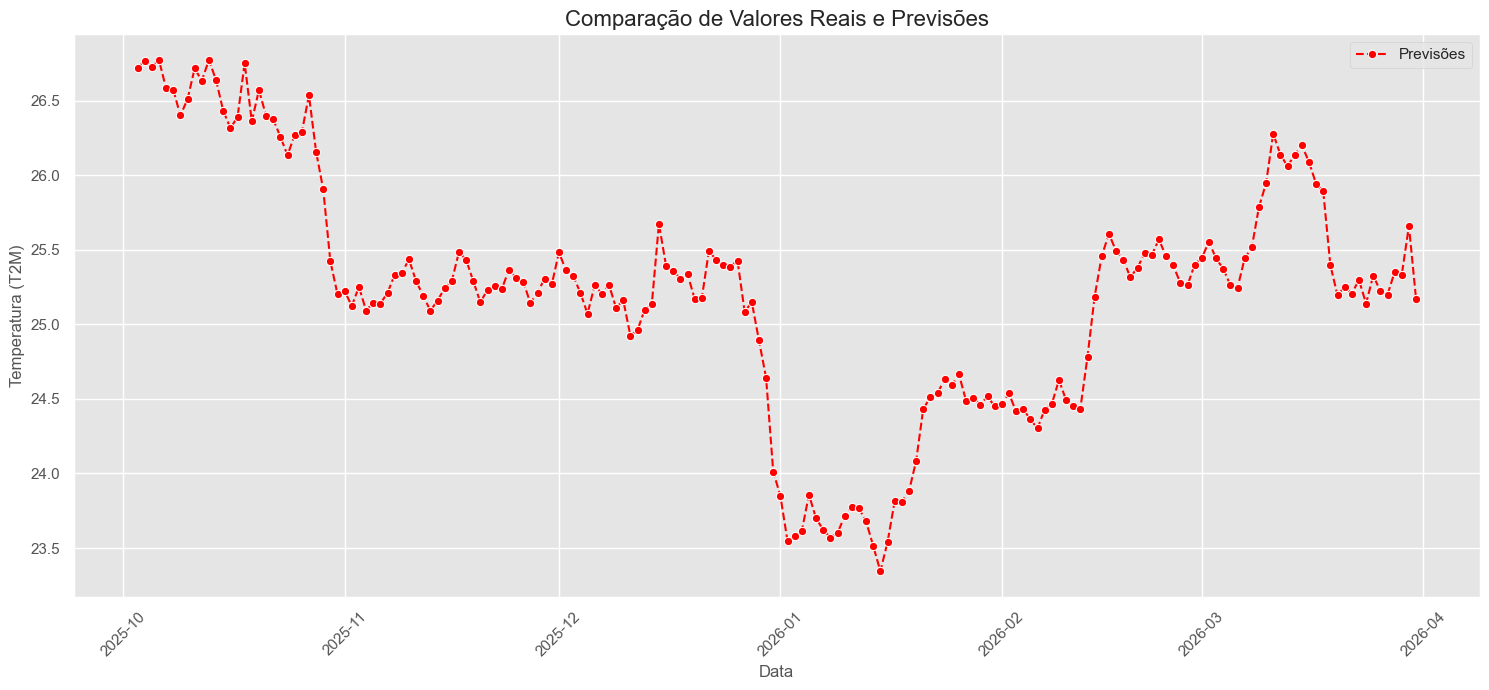

In [48]:
# Configura o estilo do gráfico
sns.set_theme(style="whitegrid")
plt.style.use('ggplot')

# Cria o gráfico
plt.figure(figsize=(15, 7))

# Plota os valores reais (WS2M)
#sns.lineplot(data=df_previsoes, x='date', y='T2M', label='Valores Reais', marker='o', color='blue')

# Plota as previsões
sns.lineplot(data=df_previsoes, x='date', y='prediction', label='Previsões', marker='o', color='red', linestyle='--')

# Adiciona título e rótulos
plt.title('Comparação de Valores Reais e Previsões', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Temperatura (T2M)', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout() # Ajusta o layout para evitar sobreposição
plt.show()

In [49]:
df_previsoes.to_csv('forecast/forecast_T2M.csv')

## Temperatura Máxima

In [54]:
target_t2m = 'T2M_MAX'
features_t2m = selecionar_features_recursivas(target_t2m)
print(f'Features para {target_t2m}:')
print(features_t2m)

X_train = train_udi[features_t2m]
y_train = train_udi[target_t2m]

X_valid = valid_udi[features_t2m]
y_valid = valid_udi[target_t2m]

model_xgb = XGBRegressor(n_estimators=2000, 
                         learning_rate=0.1, 
                         max_depth=5, 
                         random_state=42)

model_xgb.fit(X_train, y_train)

Features para T2M_MAX:
['T2M_MAX_L1D', 'T2M_MAX_L2D', 'T2M_MAX_L7D', 'T2M_MAX_L15D', 'T2M_MAX_L30D', 'T2M_MAX_L60D', 'T2M_MAX_L90D', 'T2M_MAX_L120D', 'T2M_MAX_L150D', 'T2M_MAX_L180D', 'T2M_MAX_L210D', 'T2M_MAX_L240D', 'T2M_MAX_L270D', 'T2M_MAX_L300D', 'T2M_MAX_L330D', 'T2M_MAX_L365D', 'SOI', 'SOI_L1M', 'SOI_L2M', 'SOI_L3M', 'ANOM', 'ANOM_L1M', 'ANOM_L2M', 'ANOM_L3M', 'month', 'day_of_year', 'day_of_week', 'week_of_year', 'is_weekend', 'day_of_year_sin', 'day_of_year_cos', 'week_of_year_sin', 'week_of_year_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'year']


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [55]:
import pandas as pd
import numpy as np
import xgboost as xgb

# Assuming your model_xgb and data are already loaded

# The variable-target to predict
target_col = target_t2m

# Number of days to predict
n_dias_prever = 180

# Create a DataFrame to store the predictions
last_train_date = pd.to_datetime('2025-10-02')
future_dates = pd.date_range(start=last_train_date, periods=n_dias_prever + 1, freq='D')
df_previsoes = pd.DataFrame(index=future_dates, columns=['prediction'])

# Get the last row of your training data
last_train_data = X_train.iloc[[-1]].copy()

# Get the last known values of monthly variables
last_soi = last_train_data['SOI'].values[0]
last_soi_lags = {lag: last_train_data[f'SOI_L{lag}M'].values[0] for lag in [1, 2, 3]}

last_anom = last_train_data['ANOM'].values[0]
last_anom_lags = {lag: last_train_data[f'ANOM_L{lag}M'].values[0] for lag in [1, 2, 3]}

# Start the prediction loop
for i in range(n_dias_prever):
    
    # 1. Get the data for the current row to be predicted
    row_to_predict = last_train_data.copy()
    
    # Update the seasonality and date variables
    current_date = future_dates[i + 1]
    
    row_to_predict['month'] = current_date.month
    row_to_predict['day_of_year'] = current_date.dayofyear
    row_to_predict['day_of_week'] = current_date.dayofweek
    row_to_predict['week_of_year'] = current_date.isocalendar().week
    
    # Correction here: convert boolean to integer directly by multiplying by 1
    row_to_predict['is_weekend'] = (current_date.weekday() >= 5) * 1
    
    row_to_predict['day_of_year_sin'] = np.sin(2 * np.pi * row_to_predict['day_of_year'] / 365.25)
    row_to_predict['day_of_year_cos'] = np.cos(2 * np.pi * row_to_predict['day_of_year'] / 365.25)
    row_to_predict['week_of_year_sin'] = np.sin(2 * np.pi * row_to_predict['week_of_year'] / 52.0)
    row_to_predict['week_of_year_cos'] = np.cos(2 * np.pi * row_to_predict['week_of_year'] / 52.0)
    row_to_predict['day_of_week_sin'] = np.sin(2 * np.pi * row_to_predict['day_of_week'] / 7.0)
    row_to_predict['day_of_week_cos'] = np.cos(2 * np.pi * row_to_predict['day_of_week'] / 7.0)
    row_to_predict['month_sin'] = np.sin(2 * np.pi * row_to_predict['month'] / 12.0)
    row_to_predict['month_cos'] = np.cos(2 * np.pi * row_to_predict['month'] / 12.0)
    row_to_predict['year'] = current_date.year
    
    # Fill in monthly lags with the last known value
    row_to_predict['SOI'] = last_soi
    for lag, val in last_soi_lags.items():
        row_to_predict[f'SOI_L{lag}M'] = val
        
    row_to_predict['ANOM'] = last_anom
    for lag, val in last_anom_lags.items():
        row_to_predict[f'ANOM_L{lag}M'] = val
        
    # 2. Make the prediction for the current loop date
    pred = model_xgb.predict(row_to_predict)
    df_previsoes.loc[current_date, 'prediction'] = pred[0]
    
    # 3. Prepare for the next iteration
    # Update the target variable lags with the new prediction
    last_train_data[f'{target_col}_L1D'] = pred[0]
    
    # Shift the other lags
    lags = [2, 7, 15, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 365]
    for lag in lags:
        if f'{target_col}_L{lag - 1}D' in last_train_data.columns:
            prev_lag_col = f'{target_col}_L{lag - 1}D'
            last_train_data[f'{target_col}_L{lag}D'] = last_train_data[prev_lag_col].values[0]

# Display the predictions DataFrame
print(df_previsoes.head())
print("\n...")
print(df_previsoes.tail())

           prediction
2025-10-02        NaN
2025-10-03  34.490833
2025-10-04  32.579857
2025-10-05  32.345726
2025-10-06  32.052277

...
           prediction
2026-03-27  28.621214
2026-03-28  28.637449
2026-03-29  28.622847
2026-03-30  28.778563
2026-03-31  28.671068


In [56]:
df_previsoes = df_previsoes.reset_index(names=['date'])
df_previsoes['date'] = pd.to_datetime(df_previsoes['date'])

real = valid_udi[['T2M_MAX', 'date']].copy()
real['date'] = pd.to_datetime(real['date'])

df_previsoes = df_previsoes.merge(real, how='left', on='date')

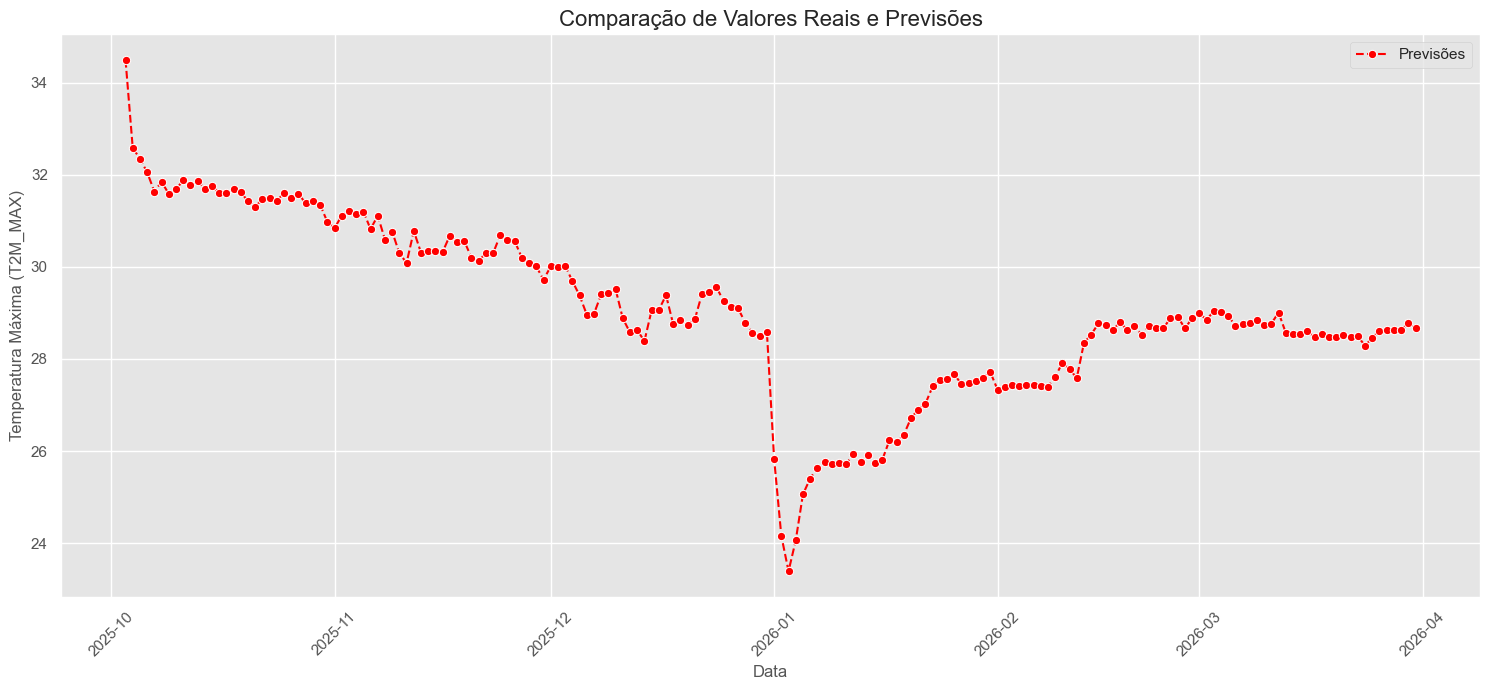

In [57]:
# Configura o estilo do gráfico
sns.set_theme(style="whitegrid")
plt.style.use('ggplot')

# Cria o gráfico
plt.figure(figsize=(15, 7))

# Plota os valores reais (WS2M)
#sns.lineplot(data=df_previsoes, x='date', y='T2M_MAX', label='Valores Reais', marker='o', color='blue')

# Plota as previsões
sns.lineplot(data=df_previsoes, x='date', y='prediction', label='Previsões', marker='o', color='red', linestyle='--')

# Adiciona título e rótulos
plt.title('Comparação de Valores Reais e Previsões', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Temperatura Máxima (T2M_MAX)', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout() # Ajusta o layout para evitar sobreposição
plt.show()

In [58]:
df_previsoes.to_csv('forecast/forecast_T2M_MAX.csv')

## Temperatura Minima

In [87]:
target_t2m = 'T2M_MIN'
features_t2m = selecionar_features_recursivas(target_t2m)
print(f'Features para {target_t2m}:')
print(features_t2m)

X_train = train_udi[features_t2m]
y_train = train_udi[target_t2m]

X_valid = valid_udi[features_t2m]
y_valid = valid_udi[target_t2m]

model_xgb = XGBRegressor(n_estimators=2000, 
                         learning_rate=0.6, 
                         max_depth=5, 
                         random_state=42)

model_xgb.fit(X_train, y_train)

Features para T2M_MIN:
['T2M_MIN_L1D', 'T2M_MIN_L2D', 'T2M_MIN_L7D', 'T2M_MIN_L15D', 'T2M_MIN_L30D', 'T2M_MIN_L60D', 'T2M_MIN_L90D', 'T2M_MIN_L120D', 'T2M_MIN_L150D', 'T2M_MIN_L180D', 'T2M_MIN_L210D', 'T2M_MIN_L240D', 'T2M_MIN_L270D', 'T2M_MIN_L300D', 'T2M_MIN_L330D', 'T2M_MIN_L365D', 'SOI', 'SOI_L1M', 'SOI_L2M', 'SOI_L3M', 'ANOM', 'ANOM_L1M', 'ANOM_L2M', 'ANOM_L3M', 'month', 'day_of_year', 'day_of_week', 'week_of_year', 'is_weekend', 'day_of_year_sin', 'day_of_year_cos', 'week_of_year_sin', 'week_of_year_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'year']


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [88]:
import pandas as pd
import numpy as np
import xgboost as xgb

# Assuming your model_xgb and data are already loaded

# The variable-target to predict
target_col = target_t2m

# Number of days to predict
n_dias_prever = 180

# Create a DataFrame to store the predictions
last_train_date = pd.to_datetime('2025-10-02')
future_dates = pd.date_range(start=last_train_date, periods=n_dias_prever + 1, freq='D')
df_previsoes = pd.DataFrame(index=future_dates, columns=['prediction'])

# Get the last row of your training data
last_train_data = X_train.iloc[[-1]].copy()

# Get the last known values of monthly variables
last_soi = last_train_data['SOI'].values[0]
last_soi_lags = {lag: last_train_data[f'SOI_L{lag}M'].values[0] for lag in [1, 2, 3]}

last_anom = last_train_data['ANOM'].values[0]
last_anom_lags = {lag: last_train_data[f'ANOM_L{lag}M'].values[0] for lag in [1, 2, 3]}

# Start the prediction loop
for i in range(n_dias_prever):
    
    # 1. Get the data for the current row to be predicted
    row_to_predict = last_train_data.copy()
    
    # Update the seasonality and date variables
    current_date = future_dates[i + 1]
    
    row_to_predict['month'] = current_date.month
    row_to_predict['day_of_year'] = current_date.dayofyear
    row_to_predict['day_of_week'] = current_date.dayofweek
    row_to_predict['week_of_year'] = current_date.isocalendar().week
    
    # Correction here: convert boolean to integer directly by multiplying by 1
    row_to_predict['is_weekend'] = (current_date.weekday() >= 5) * 1
    
    row_to_predict['day_of_year_sin'] = np.sin(2 * np.pi * row_to_predict['day_of_year'] / 365.25)
    row_to_predict['day_of_year_cos'] = np.cos(2 * np.pi * row_to_predict['day_of_year'] / 365.25)
    row_to_predict['week_of_year_sin'] = np.sin(2 * np.pi * row_to_predict['week_of_year'] / 52.0)
    row_to_predict['week_of_year_cos'] = np.cos(2 * np.pi * row_to_predict['week_of_year'] / 52.0)
    row_to_predict['day_of_week_sin'] = np.sin(2 * np.pi * row_to_predict['day_of_week'] / 7.0)
    row_to_predict['day_of_week_cos'] = np.cos(2 * np.pi * row_to_predict['day_of_week'] / 7.0)
    row_to_predict['month_sin'] = np.sin(2 * np.pi * row_to_predict['month'] / 12.0)
    row_to_predict['month_cos'] = np.cos(2 * np.pi * row_to_predict['month'] / 12.0)
    row_to_predict['year'] = current_date.year
    
    # Fill in monthly lags with the last known value
    row_to_predict['SOI'] = last_soi
    for lag, val in last_soi_lags.items():
        row_to_predict[f'SOI_L{lag}M'] = val
        
    row_to_predict['ANOM'] = last_anom
    for lag, val in last_anom_lags.items():
        row_to_predict[f'ANOM_L{lag}M'] = val
        
    # 2. Make the prediction for the current loop date
    pred = model_xgb.predict(row_to_predict)
    df_previsoes.loc[current_date, 'prediction'] = pred[0]
    
    # 3. Prepare for the next iteration
    # Update the target variable lags with the new prediction
    last_train_data[f'{target_col}_L1D'] = pred[0]
    
    # Shift the other lags
    lags = [2, 7, 15, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 365]
    for lag in lags:
        if f'{target_col}_L{lag - 1}D' in last_train_data.columns:
            prev_lag_col = f'{target_col}_L{lag - 1}D'
            last_train_data[f'{target_col}_L{lag}D'] = last_train_data[prev_lag_col].values[0]

# Display the predictions DataFrame
print(df_previsoes.head())
print("\n...")
print(df_previsoes.tail())

           prediction
2025-10-02        NaN
2025-10-03  18.828114
2025-10-04  18.280788
2025-10-05   18.43294
2025-10-06  18.694035

...
           prediction
2026-03-27  19.190262
2026-03-28  19.024281
2026-03-29  19.028191
2026-03-30  19.075899
2026-03-31  19.016325


In [89]:
df_previsoes = df_previsoes.reset_index(names=['date'])
df_previsoes['date'] = pd.to_datetime(df_previsoes['date'])

real = valid_udi[['T2M_MIN', 'date']].copy()
real['date'] = pd.to_datetime(real['date'])

df_previsoes = df_previsoes.merge(real, how='left', on='date')

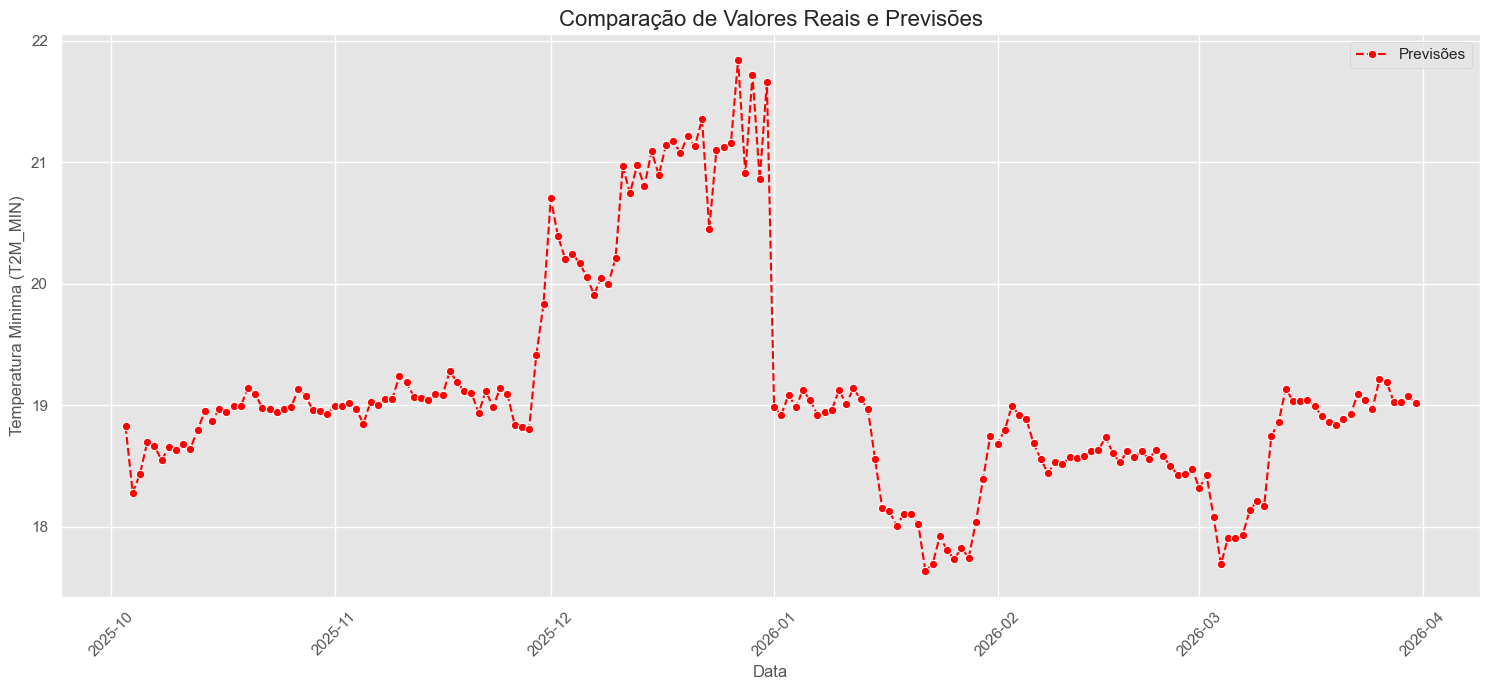

In [90]:
# Configura o estilo do gráfico
sns.set_theme(style="whitegrid")
plt.style.use('ggplot')

# Cria o gráfico
plt.figure(figsize=(15, 7))

# Plota os valores reais (WS2M)
#sns.lineplot(data=df_previsoes, x='date', y='T2M_MIN', label='Valores Reais', marker='o', color='blue')

# Plota as previsões
sns.lineplot(data=df_previsoes, x='date', y='prediction', label='Previsões', marker='o', color='red', linestyle='--')

# Adiciona título e rótulos
plt.title('Comparação de Valores Reais e Previsões', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Temperatura Minima (T2M_MIN)', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout() # Ajusta o layout para evitar sobreposição
plt.show()

In [91]:
df_previsoes.to_csv('forecast/forecast_T2M_MIN.csv')

## Umidade

In [92]:
target_t2m = 'RH2M'
features_t2m = selecionar_features_recursivas(target_t2m)
print(f'Features para {target_t2m}:')
print(features_t2m)

X_train = train_udi[features_t2m]
y_train = train_udi[target_t2m]

X_valid = valid_udi[features_t2m]
y_valid = valid_udi[target_t2m]

model_xgb = XGBRegressor(n_estimators=2000, 
                         learning_rate=0.2, 
                         max_depth=5, 
                         random_state=42)

model_xgb.fit(X_train, y_train)

Features para RH2M:
['RH2M_L1D', 'RH2M_L2D', 'RH2M_L7D', 'RH2M_L15D', 'RH2M_L30D', 'RH2M_L60D', 'RH2M_L90D', 'RH2M_L120D', 'RH2M_L150D', 'RH2M_L180D', 'RH2M_L210D', 'RH2M_L240D', 'RH2M_L270D', 'RH2M_L300D', 'RH2M_L330D', 'RH2M_L365D', 'SOI', 'SOI_L1M', 'SOI_L2M', 'SOI_L3M', 'ANOM', 'ANOM_L1M', 'ANOM_L2M', 'ANOM_L3M', 'month', 'day_of_year', 'day_of_week', 'week_of_year', 'is_weekend', 'day_of_year_sin', 'day_of_year_cos', 'week_of_year_sin', 'week_of_year_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'year']


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [93]:
import pandas as pd
import numpy as np
import xgboost as xgb

# Assuming your model_xgb and data are already loaded

# The variable-target to predict
target_col = target_t2m

# Number of days to predict
n_dias_prever = 180

# Create a DataFrame to store the predictions
last_train_date = pd.to_datetime('2025-10-02')
future_dates = pd.date_range(start=last_train_date, periods=n_dias_prever + 1, freq='D')
df_previsoes = pd.DataFrame(index=future_dates, columns=['prediction'])

# Get the last row of your training data
last_train_data = X_train.iloc[[-1]].copy()

# Get the last known values of monthly variables
last_soi = last_train_data['SOI'].values[0]
last_soi_lags = {lag: last_train_data[f'SOI_L{lag}M'].values[0] for lag in [1, 2, 3]}

last_anom = last_train_data['ANOM'].values[0]
last_anom_lags = {lag: last_train_data[f'ANOM_L{lag}M'].values[0] for lag in [1, 2, 3]}

# Start the prediction loop
for i in range(n_dias_prever):
    
    # 1. Get the data for the current row to be predicted
    row_to_predict = last_train_data.copy()
    
    # Update the seasonality and date variables
    current_date = future_dates[i + 1]
    
    row_to_predict['month'] = current_date.month
    row_to_predict['day_of_year'] = current_date.dayofyear
    row_to_predict['day_of_week'] = current_date.dayofweek
    row_to_predict['week_of_year'] = current_date.isocalendar().week
    
    # Correction here: convert boolean to integer directly by multiplying by 1
    row_to_predict['is_weekend'] = (current_date.weekday() >= 5) * 1
    
    row_to_predict['day_of_year_sin'] = np.sin(2 * np.pi * row_to_predict['day_of_year'] / 365.25)
    row_to_predict['day_of_year_cos'] = np.cos(2 * np.pi * row_to_predict['day_of_year'] / 365.25)
    row_to_predict['week_of_year_sin'] = np.sin(2 * np.pi * row_to_predict['week_of_year'] / 52.0)
    row_to_predict['week_of_year_cos'] = np.cos(2 * np.pi * row_to_predict['week_of_year'] / 52.0)
    row_to_predict['day_of_week_sin'] = np.sin(2 * np.pi * row_to_predict['day_of_week'] / 7.0)
    row_to_predict['day_of_week_cos'] = np.cos(2 * np.pi * row_to_predict['day_of_week'] / 7.0)
    row_to_predict['month_sin'] = np.sin(2 * np.pi * row_to_predict['month'] / 12.0)
    row_to_predict['month_cos'] = np.cos(2 * np.pi * row_to_predict['month'] / 12.0)
    row_to_predict['year'] = current_date.year
    
    # Fill in monthly lags with the last known value
    row_to_predict['SOI'] = last_soi
    for lag, val in last_soi_lags.items():
        row_to_predict[f'SOI_L{lag}M'] = val
        
    row_to_predict['ANOM'] = last_anom
    for lag, val in last_anom_lags.items():
        row_to_predict[f'ANOM_L{lag}M'] = val
        
    # 2. Make the prediction for the current loop date
    pred = model_xgb.predict(row_to_predict)
    df_previsoes.loc[current_date, 'prediction'] = pred[0]
    
    # 3. Prepare for the next iteration
    # Update the target variable lags with the new prediction
    last_train_data[f'{target_col}_L1D'] = pred[0]
    
    # Shift the other lags
    lags = [2, 7, 15, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 365]
    for lag in lags:
        if f'{target_col}_L{lag - 1}D' in last_train_data.columns:
            prev_lag_col = f'{target_col}_L{lag - 1}D'
            last_train_data[f'{target_col}_L{lag}D'] = last_train_data[prev_lag_col].values[0]

# Display the predictions DataFrame
print(df_previsoes.head())
print("\n...")
print(df_previsoes.tail())

           prediction
2025-10-02        NaN
2025-10-03    31.9536
2025-10-04  32.900856
2025-10-05  32.414757
2025-10-06  33.310295

...
           prediction
2026-03-27  43.941235
2026-03-28  43.514263
2026-03-29  41.692875
2026-03-30  44.982128
2026-03-31  48.157394


In [94]:
df_previsoes = df_previsoes.reset_index(names=['date'])
df_previsoes['date'] = pd.to_datetime(df_previsoes['date'])

real = valid_udi[['RH2M', 'date']].copy()
real['date'] = pd.to_datetime(real['date'])

df_previsoes = df_previsoes.merge(real, how='left', on='date')

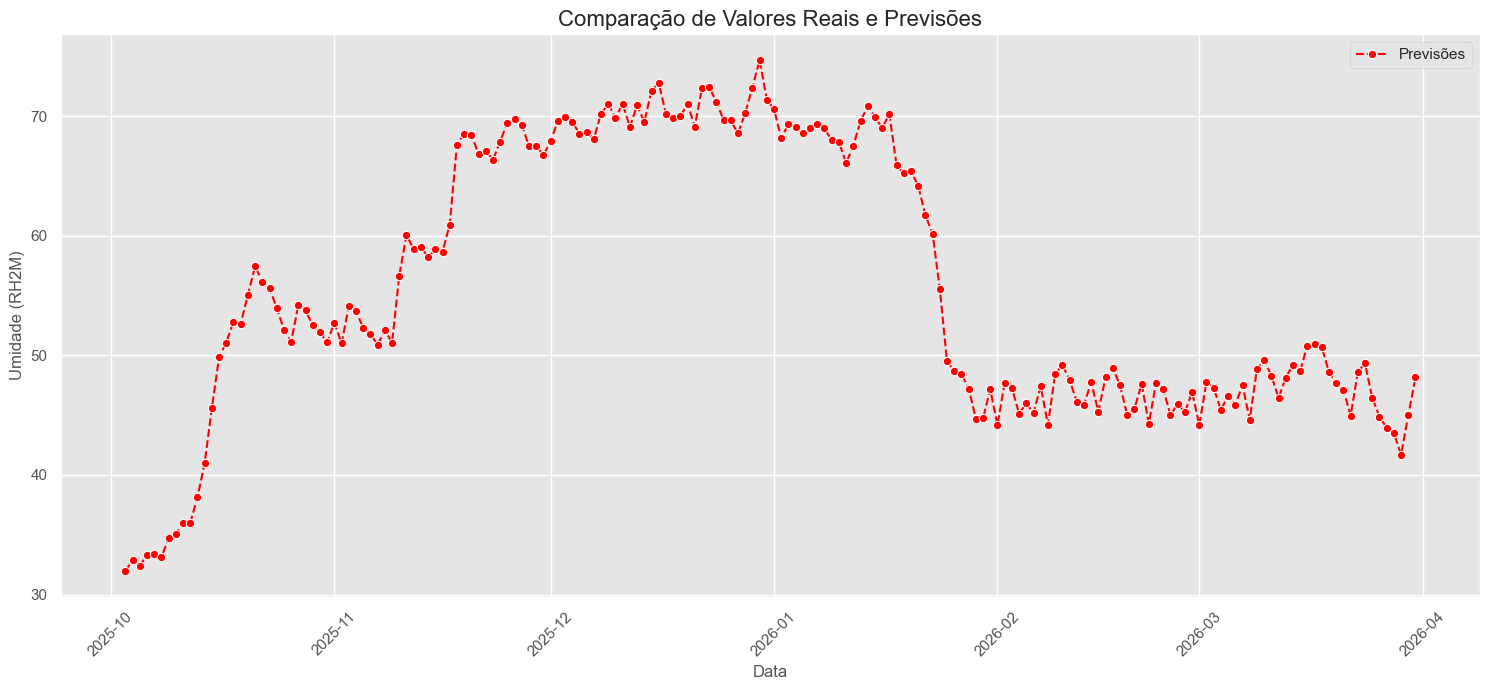

In [95]:
# Configura o estilo do gráfico
sns.set_theme(style="whitegrid")
plt.style.use('ggplot')

# Cria o gráfico
plt.figure(figsize=(15, 7))

# Plota os valores reais (WS2M)
#sns.lineplot(data=df_previsoes, x='date', y='RH2M', label='Valores Reais', marker='o', color='blue')

# Plota as previsões
sns.lineplot(data=df_previsoes, x='date', y='prediction', label='Previsões', marker='o', color='red', linestyle='--')

# Adiciona título e rótulos
plt.title('Comparação de Valores Reais e Previsões', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Umidade (RH2M)', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout() # Ajusta o layout para evitar sobreposição
plt.show()

In [96]:
df_previsoes.to_csv('forecast/forecast_RH2M.csv')

## Velocidade do Vento

In [97]:
target_t2m = 'WS2M'
features_t2m = selecionar_features_recursivas(target_t2m)
print(f'Features para {target_t2m}:')
print(features_t2m)

X_train = train_udi[features_t2m]
y_train = train_udi[target_t2m]

X_valid = valid_udi[features_t2m]
y_valid = valid_udi[target_t2m]

model_xgb = XGBRegressor(n_estimators=2000, 
                         learning_rate=0.7, 
                         max_depth=5, 
                         random_state=42)

model_xgb.fit(X_train, y_train)

Features para WS2M:
['WS2M_L1D', 'WS2M_L2D', 'WS2M_L7D', 'WS2M_L15D', 'WS2M_L30D', 'WS2M_L60D', 'WS2M_L90D', 'WS2M_L120D', 'WS2M_L150D', 'WS2M_L180D', 'WS2M_L210D', 'WS2M_L240D', 'WS2M_L270D', 'WS2M_L300D', 'WS2M_L330D', 'WS2M_L365D', 'SOI', 'SOI_L1M', 'SOI_L2M', 'SOI_L3M', 'ANOM', 'ANOM_L1M', 'ANOM_L2M', 'ANOM_L3M', 'month', 'day_of_year', 'day_of_week', 'week_of_year', 'is_weekend', 'day_of_year_sin', 'day_of_year_cos', 'week_of_year_sin', 'week_of_year_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'year']


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [99]:
import pandas as pd
import numpy as np
import xgboost as xgb

# Assuming your model_xgb and data are already loaded

# The variable-target to predict
target_col = target_t2m

# Number of days to predict
n_dias_prever = 180

# Create a DataFrame to store the predictions
last_train_date = pd.to_datetime('2025-10-02')
future_dates = pd.date_range(start=last_train_date, periods=n_dias_prever + 1, freq='D')
df_previsoes = pd.DataFrame(index=future_dates, columns=['prediction'])

# Get the last row of your training data
last_train_data = X_train.iloc[[-1]].copy()

# Get the last known values of monthly variables
last_soi = last_train_data['SOI'].values[0]
last_soi_lags = {lag: last_train_data[f'SOI_L{lag}M'].values[0] for lag in [1, 2, 3]}

last_anom = last_train_data['ANOM'].values[0]
last_anom_lags = {lag: last_train_data[f'ANOM_L{lag}M'].values[0] for lag in [1, 2, 3]}

# Start the prediction loop
for i in range(n_dias_prever):
    
    # 1. Get the data for the current row to be predicted
    row_to_predict = last_train_data.copy()
    
    # Update the seasonality and date variables
    current_date = future_dates[i + 1]
    
    row_to_predict['month'] = current_date.month
    row_to_predict['day_of_year'] = current_date.dayofyear
    row_to_predict['day_of_week'] = current_date.dayofweek
    row_to_predict['week_of_year'] = current_date.isocalendar().week
    
    # Correction here: convert boolean to integer directly by multiplying by 1
    row_to_predict['is_weekend'] = (current_date.weekday() >= 5) * 1
    
    row_to_predict['day_of_year_sin'] = np.sin(2 * np.pi * row_to_predict['day_of_year'] / 365.25)
    row_to_predict['day_of_year_cos'] = np.cos(2 * np.pi * row_to_predict['day_of_year'] / 365.25)
    row_to_predict['week_of_year_sin'] = np.sin(2 * np.pi * row_to_predict['week_of_year'] / 52.0)
    row_to_predict['week_of_year_cos'] = np.cos(2 * np.pi * row_to_predict['week_of_year'] / 52.0)
    row_to_predict['day_of_week_sin'] = np.sin(2 * np.pi * row_to_predict['day_of_week'] / 7.0)
    row_to_predict['day_of_week_cos'] = np.cos(2 * np.pi * row_to_predict['day_of_week'] / 7.0)
    row_to_predict['month_sin'] = np.sin(2 * np.pi * row_to_predict['month'] / 12.0)
    row_to_predict['month_cos'] = np.cos(2 * np.pi * row_to_predict['month'] / 12.0)
    row_to_predict['year'] = current_date.year
    
    # Fill in monthly lags with the last known value
    row_to_predict['SOI'] = last_soi
    for lag, val in last_soi_lags.items():
        row_to_predict[f'SOI_L{lag}M'] = val
        
    row_to_predict['ANOM'] = last_anom
    for lag, val in last_anom_lags.items():
        row_to_predict[f'ANOM_L{lag}M'] = val
        
    # 2. Make the prediction for the current loop date
    pred = model_xgb.predict(row_to_predict)
    df_previsoes.loc[current_date, 'prediction'] = pred[0]
    
    # 3. Prepare for the next iteration
    # Update the target variable lags with the new prediction
    last_train_data[f'{target_col}_L1D'] = pred[0]
    
    # Shift the other lags
    lags = [2, 7, 15, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 365]
    for lag in lags:
        if f'{target_col}_L{lag - 1}D' in last_train_data.columns:
            prev_lag_col = f'{target_col}_L{lag - 1}D'
            last_train_data[f'{target_col}_L{lag}D'] = last_train_data[prev_lag_col].values[0]

# Display the predictions DataFrame
print(df_previsoes.head())
print("\n...")
print(df_previsoes.tail())

           prediction
2025-10-02        NaN
2025-10-03   2.381567
2025-10-04   2.051201
2025-10-05   2.256401
2025-10-06   2.077857

...
           prediction
2026-03-27    1.53639
2026-03-28    1.46936
2026-03-29   1.294767
2026-03-30   1.304461
2026-03-31   1.281234


In [100]:
df_previsoes = df_previsoes.reset_index(names=['date'])
df_previsoes['date'] = pd.to_datetime(df_previsoes['date'])

real = valid_udi[['WS2M', 'date']].copy()
real['date'] = pd.to_datetime(real['date'])

df_previsoes = df_previsoes.merge(real, how='left', on='date')

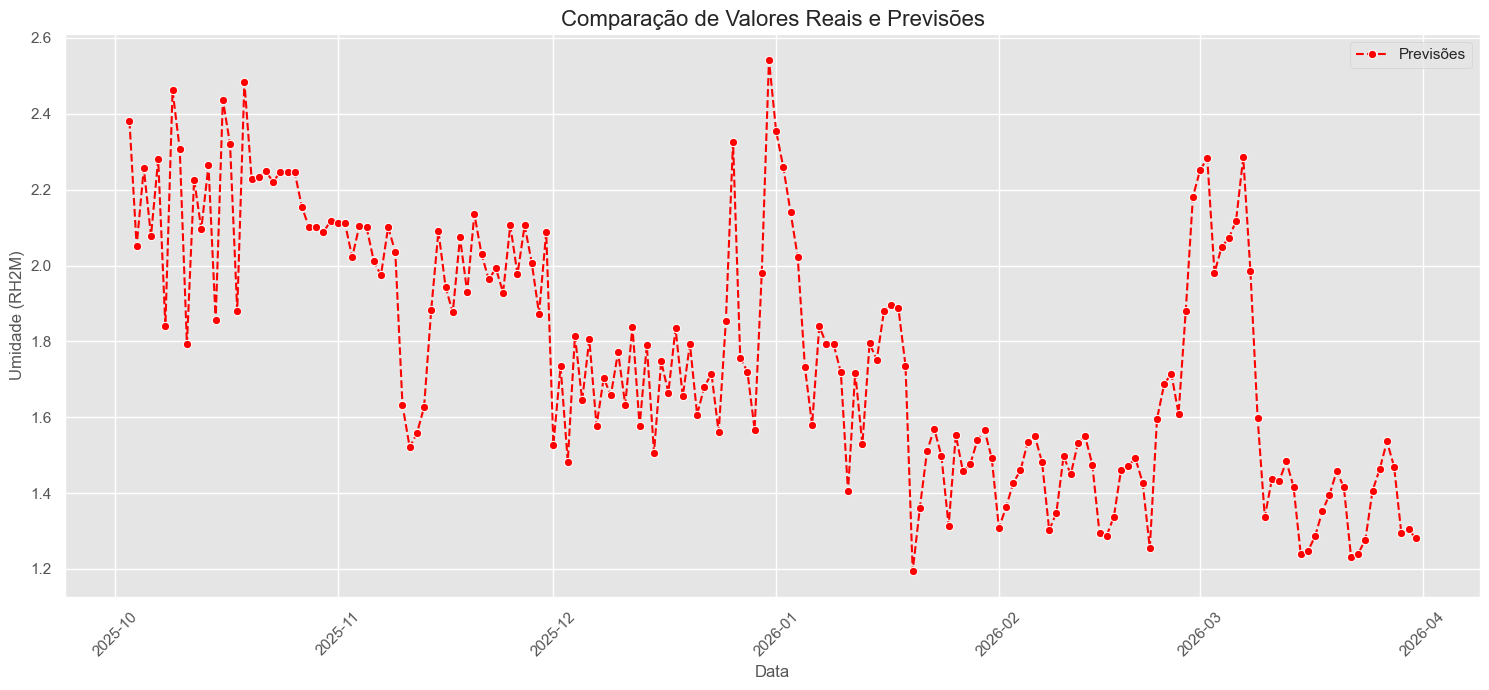

In [101]:
# Configura o estilo do gráfico
sns.set_theme(style="whitegrid")
plt.style.use('ggplot')

# Cria o gráfico
plt.figure(figsize=(15, 7))

# Plota os valores reais (WS2M)
#sns.lineplot(data=df_previsoes, x='date', y='WS2M', label='Valores Reais', marker='o', color='blue')

# Plota as previsões
sns.lineplot(data=df_previsoes, x='date', y='prediction', label='Previsões', marker='o', color='red', linestyle='--')

# Adiciona título e rótulos
plt.title('Comparação de Valores Reais e Previsões', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Umidade (RH2M)', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout() # Ajusta o layout para evitar sobreposição
plt.show()

In [102]:
df_previsoes.to_csv('forecast/forecast_WS2M.csv')